## Asymmetric omics prediction using spaAnchor

In this section, we illustrate spaAnchor for asymmetric omics prediction.

We use the MERFISH obtained [mouse liver dataset](https://www.10xgenomics.com/datasets/ffpe-human-breast-using-the-entire-sample-area-1-standard) (RNA) and RCA-MERFISH obtained [mouse liver dataset](https://huggingface.co/datasets/xingjiepan/PerturbMulti/tree/main) (RNA, Protein, Annotation) for evaluation.
We use the co-profiled expression panel as anchor to predict the unmeasured gene expression, protein expression, and annotation from the small RCA-MERFISH dataset to the large MERFISH dataset.

In [1]:
import spaAnchor as sa
import scanpy as sc
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

adata0 = sc.read("/mnt/sde/data/merfish/mouse_liver_multiomics/adlib.h5ad")
adata0 = adata0["1_2" == adata0.obs["slice_id"], ["Blank" not in name for name in adata0.var_names]].copy()
adata1 = sc.read("/mnt/sde/data/merfish/mouse_liver/a1s1.h5ad")
adata0.var_names_make_unique()
adata1.var_names_make_unique()

# Preprocess adata1's input features, 
# since the features in adata0 is already preprocessed
sc.pp.normalize_total(adata1, target_sum=1e4)
sc.pp.log1p(adata1)
sc.pp.scale(adata1, max_value=10)

User should structure their input data within an `sc.AnnData` object as follows. Ensure that all feature matrices are aligned, with rows corresponding to the same cells/spots in the same order.

- Gene expression feature at `adata.X`
- Protein expression feature at `adata.obsm["protein"]`
- Annotation at `adata.obsm["annotation"]`  
Note: Annotation labels should be one-hot encoded.

Features should be stored as a `pd.DataFrame` data structure.

In [2]:
protein_idx = ['Alb', 'M6PR', 'CathB', 'Perilipin', 'Sqstm1', 'LC3b', 
'TOMM20', 'Calreticulin', 'pS6RP', 'Na+/K+ATPase', 'SNAP23', 'TOM70', 
'Rab7', 'Vimentin', 'Gapdh']
adata0.obsm["protein"] = pd.DataFrame(adata0.obs[protein_idx].to_numpy(), 
                                      index=adata0.obs_names, columns=protein_idx)

# Filter the protein non expressed cells
idx = np.ones(adata0.shape[0])
idx[np.nonzero(np.isnan(adata0.obsm["protein"]).sum(axis=1))[0]] = 0
adata0 = adata0[idx.astype(bool)]

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(adata0.obs["condition"].to_numpy().reshape(-1, 1))
onehot_label = enc.transform(adata0.obs["condition"].to_numpy().reshape(-1, 1)).toarray()
adata0.obsm["annotation"] = pd.DataFrame(onehot_label, 
                            index=adata0.obs_names, columns=range(onehot_label.shape[1]))

By storing features as we set, the user can use our pre-build `sa.asymmetric` class for prediction.
Since we only need to predict feature from the RCA-MERFISH slice to MERFISH slice, we can specify the `tgt_id` to let the model predict feature for the designated target slice, set `tgt_id[1][0] = True` if you want to predict feature from slice 0 to slice 1. 
Model will predict all type of features you designated at `feature_key`.

In [3]:
tgt_id = np.zeros((2, 2), dtype=np.bool_)
tgt_id[1][0] = True

model = sa.asymmetric_translation(preprocess=False, feature_key=["X", "protein", "annotation"])
predicted_result = model([adata0.copy(), adata1.copy()], tgt_id)

INFO: Finish preprocessing. (1.410s)
INFO: Generate 145,139 edges, average 3.499 edges per cell.
INFO: Generate 1,378,538 edges, average 3.500 edges per cell.
INFO: Finish latent embedding generating. (42.544s)
INFO: Finish HANN pairs finding. (41.965s)


INFO: Learn aggregate attention score: 100%|██████████| 500/500 [00:06<00:00, 82.33it/s]


INFO: Finish transformation. (86.224s)


After prediction, user can visualize the spatial distribution of important gene markers. 

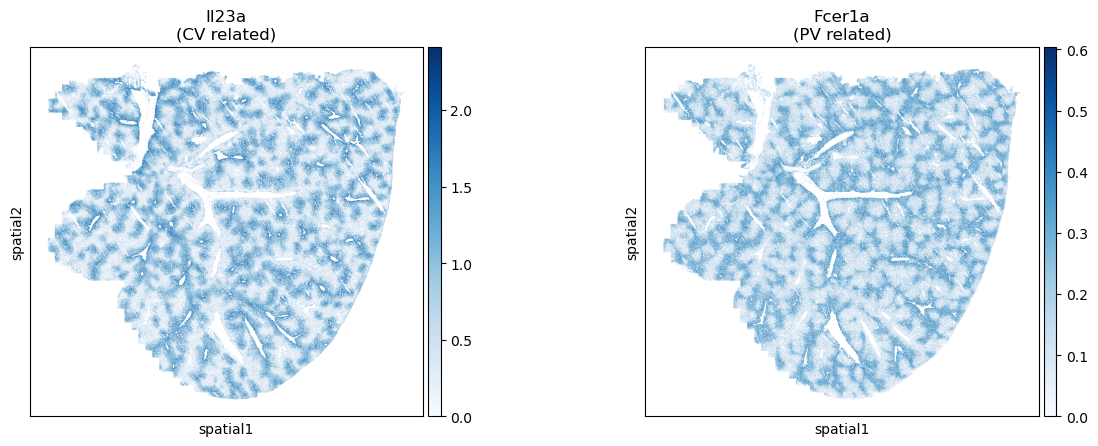

In [4]:
adata1.obs_names += "-1"
result_adata1 = adata1[predicted_result[1]["X"].index]
result_adata1.obs[["pred_il23a", "pred_fcer1a"]] = predicted_result[1]["X"][["Il23a", "Fcer1a"]]
sc.pl.spatial(result_adata1, color=["pred_il23a", "pred_fcer1a"], title=["Il23a\n(CV related)", "Fcer1a\n(PV related)"], cmap="Blues", spot_size=20)

Using the same way, user can visualize the protein marker.

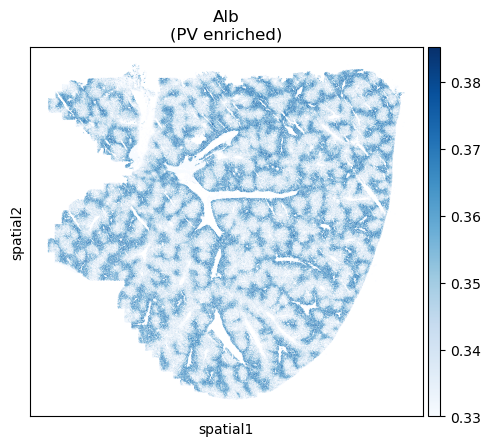

In [5]:
result_adata1.obs["pred_alb"] = predicted_result[1]["protein"]["Alb"]
sc.pl.spatial(result_adata1, color=["pred_alb"], title=["Alb\n(PV enriched)"], vmin=0.33, cmap="Blues", spot_size=20)

For predict annotation, the model will output a `pd.DataFrame` of numerical values. 
To visualize these as categories, we first need to convert them back into discrete labels by using the one-hot encoder.
Next, we can visualized the liver's zonation pattern.
Recall our biological context:
- Hep1 to Hep3 cell types are enriched in the Central Vein (CV) region.
- Hep4 to Hep6 cell types are enriched in the Portal Vein (PV) region.

A successful prediction will show clear separation of the Hep1-3 group from the Hep4-6 group, matching the known CV-PV liver architecture.

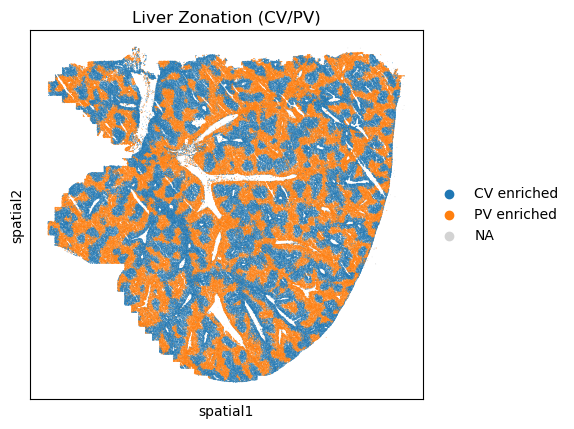

In [6]:
result_adata1.obs["pred_annotation"] = enc.inverse_transform(predicted_result[1]["annotation"].to_numpy()).reshape(-1)
region_list = np.array([None]*result_adata1.shape[0])
cv_list = ["adlib_Hep1", "adlib_Hep2", "adlib_Hep3"]
pv_list = ["adlib_Hep4", "adlib_Hep5", "adlib_Hep6"]
region_list[[i in cv_list for i in result_adata1.obs["pred_annotation"]]] = "CV enriched"
region_list[[i in pv_list for i in result_adata1.obs["pred_annotation"]]] = "PV enriched"
result_adata1.obs["pred_region"] = region_list
sc.pl.spatial(result_adata1, color=["pred_region"], title=["Liver Zonation (CV/PV)"], spot_size=20)